In [1]:
# Basic Libraries
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt # we only need pyplot
sb.set() # set the default Seaborn style for graphics

import re

In [2]:
df = pd.read_csv("df_with_latlong.csv")

In [3]:
df[['year', 'month']] = df['month'].str.split('-', expand=True)
df[['Latitude', 'Longitude']] = df['LatLong'].str.split(',', expand=True)
df["Latitude"] = df["Latitude"].astype(float)
df["Longitude"] = df["Longitude"].astype(float)
df["year"] = df["year"].astype('int64')
df["month"] = df["month"].astype('int64')

In [4]:
notuseful = ['LatLong', 'Postal code', 'Address', 'storey_range',"lease_commence_date", 'street_name', 'block']
df_SVM_working_data = df.drop(columns=notuseful)
df_SVM_working_data

,month,town,flat_type,floor_area_sqm,flat_model,remaining_lease,resale_price,nearest MRT,distance to nearest MRT,schools within 1km,nearest mall,mall nearest distance,mall within 500m,mall within 1km,hawkers within 1km,travel time to RP in minutes,year,Latitude,Longitude
0,1,ANG MO KIO,2 ROOM,44.0,Improved,61,232000.0,Ang Mo Kio,1.007304,3,AMK Hub,0.997504,0,1,3,40,2017,1.362005,103.853880
1,1,ANG MO KIO,3 ROOM,67.0,New Generation,60,250000.0,Ang Mo Kio,1.271398,7,Broadway Plaza,0.868861,0,1,4,44,2017,1.370966,103.838202
2,1,ANG MO KIO,3 ROOM,67.0,New Generation,62,262000.0,Yio Chu Kang,1.069720,6,Broadway Plaza,1.525573,0,0,2,50,2017,1.380709,103.835368
3,1,ANG MO KIO,3 ROOM,68.0,New Generation,62,265000.0,Ang Mo Kio,0.946884,3,myVillage At Serangoon Garden,0.893796,0,1,3,43,2017,1.366201,103.857201
4,1,ANG MO KIO,3 ROOM,67.0,New Generation,62,265000.0,Yio Chu Kang,1.092577,5,Broadway Plaza,1.569307,0,0,2,47,2017,1.381041,103.835132
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148268,3,YISHUN,5 ROOM,127.0,Improved,64,629000.0,Yishun,1.274187,3,Junction Nine,0.701213,0,1,1,50,2023,1.428981,103.846473
148269,3,YISHUN,5 ROOM,126.0,Improved,61,565000.0,Yishun,0.462724,9,Northpoint City,0.620131,0,2,1,48,2023,1.433722,103.836068
148270,3,YISHUN,5 ROOM,112.0,Improved,91,625000.0,Yishun,1.083451,7,Junction Nine,0.309025,1,1,1,55,2023,1.432488,103.844367
148271,3,YISHUN,5 ROOM,122.0,Improved,64,650000.0,Khatib,0.487889,5,Wisteria Mall,0.983081,0,1,0,47,2023,1.413099,103.833868


# One-hot encode town and flat type

One-hot encoding is required for the model to detect categorical data as numerical data

In [5]:
X = pd.get_dummies(df_SVM_working_data)
y = X['resale_price']
X = X.drop(columns='resale_price')

In [6]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148273 entries, 0 to 148272
Columns: 310 entries, month to nearest mall_myVillage At Serangoon Garden
dtypes: float64(5), int64(8), uint8(297)
memory usage: 56.7 MB


# Build SVR model

Build an SVR model using linear kernel to see how it performs

In [12]:
%%time
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=69)

numerical_cols = ['travel time to RP in minutes', 'hawkers within 1km', 'mall within 1km', 'mall within 500m', 'mall nearest distance', 'schools within 1km', 'distance to nearest MRT', 'remaining_lease', 'floor_area_sqm', 'month', 'year', 'Latitude', 'Longitude']
# Scale the numerical features
scaler = StandardScaler()
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

# Train the SVR model
svr = SVR(kernel='linear')
svr.fit(X_train, y_train)

# Evaluate the model
y_pred = svr.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean squared error: {mse}")
print('RMSE: ', np.sqrt(mse))
print("Accuracy: ", svr.score(X_test, y_test))

Mean squared error: 13111843681.3188
RMSE:  114506.9590955886
Accuracy:  0.5228201295348194
CPU times: user 1h 11min 9s, sys: 58.1 s, total: 1h 12min 7s
Wall time: 1h 38min 31s


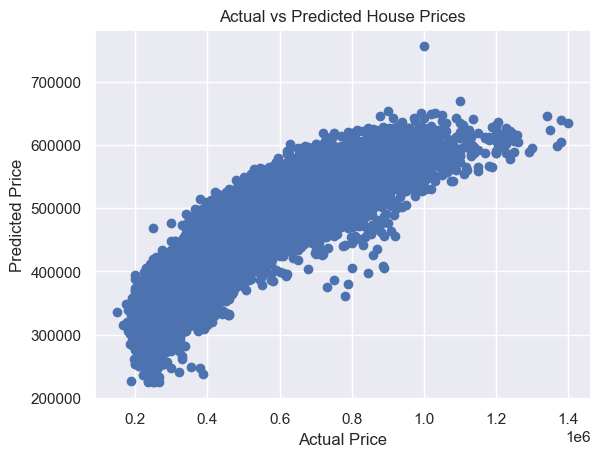

In [13]:
import matplotlib.pyplot as plt

# Plot the actual vs predicted prices
plt.scatter(y_test, y_pred)
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual vs Predicted House Prices")
plt.show()

# Hyperparameter tuning
Using grid search and random search, we want to find out the best parameters (C, kernel, gamma) to use for our model that provides the best accuracy. However, due to our large dataset, I will break it down into 10000 random samples instead and test for the best parameters to use, to improve computational time

In [7]:
df_SVM_working_data = df_SVM_working_data.sample(10000, ignore_index=True)
X = pd.get_dummies(df_SVM_working_data)
y = X['resale_price']
X = X.drop(columns='resale_price')
X

,month,floor_area_sqm,remaining_lease,distance to nearest MRT,schools within 1km,mall nearest distance,mall within 500m,mall within 1km,hawkers within 1km,travel time to RP in minutes,...,nearest mall_White Sands,nearest mall_Wisteria Mall,nearest mall_Woodlands Civic Centre,nearest mall_Woodlands Mart,nearest mall_Woodlands North Plaza,nearest mall_Yew Tee Point,nearest mall_Yew Tee Square,nearest mall_Zhongshan Mall,nearest mall_i12 Katong,nearest mall_myVillage At Serangoon Garden
0,10,75.0,59,0.809691,8,0.577184,0,4,2,47,...,0,0,0,0,0,0,0,0,0,0
1,1,73.0,69,0.330919,5,1.022132,0,0,0,48,...,0,1,0,0,0,0,0,0,0,0
2,2,93.0,94,0.149872,8,0.435609,1,2,1,55,...,0,0,0,0,0,0,0,0,0,0
3,5,74.0,61,0.828388,4,0.820667,0,1,4,29,...,0,0,0,0,0,0,0,0,0,0
4,12,112.0,93,0.196514,6,0.421103,1,2,1,57,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,12,110.0,81,0.367013,7,1.323377,0,0,1,51,...,0,0,0,0,0,0,0,0,0,0
9996,6,93.0,94,1.008874,2,0.822422,0,1,3,44,...,0,0,0,0,0,0,0,0,0,1
9997,7,74.0,66,0.506856,6,0.545102,0,3,1,46,...,0,0,0,0,0,0,0,0,0,0
9998,3,63.0,67,0.282443,1,2.260561,0,0,1,36,...,0,0,0,0,0,0,0,0,0,0


In [15]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=69)

numerical_cols = ['travel time to RP in minutes', 'hawkers within 1km', 'mall within 1km', 'mall within 500m', 'mall nearest distance', 'schools within 1km', 'distance to nearest MRT', 'remaining_lease', 'floor_area_sqm', 'month', 'year', 'Latitude', 'Longitude']
# Scale the numerical features
scaler = StandardScaler()
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

In [16]:
%%time
from sklearn.model_selection import RandomizedSearchCV

# Define the parameter grid
param = {'C': [0.1, 1, 10, 100, 1000],
              'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
              'gamma': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1.0]}

# Create an instance of randomised search
rand_search = RandomizedSearchCV(estimator= SVR(), param_distributions= param, cv= 5)

# Fit the rand search to the training data
rand_search.fit(X_train, y_train)

# Print the best hyperparameters for rand search
print('Best score using rand search:', rand_search.best_score_, '\tBest parameters:', rand_search.best_params_)

Best score using rand search: 0.8594403704190503 	Best parameters: {'kernel': 'linear', 'gamma': 0.001, 'C': 1000}
CPU times: user 7min 11s, sys: 6.18 s, total: 7min 17s
Wall time: 7min 21s


In [17]:
%%time
from sklearn.model_selection import GridSearchCV

# Create an instance of grid search
grid_search = GridSearchCV(estimator= SVR(), param_grid= param, cv= 5)

# Fit the grid search to the training data
grid_search.fit(X_train, y_train)

# Print the best hyperparameters for grid search
print('Best score using grid search:', grid_search.best_score_, '\tBest parameters:', grid_search.best_params_)

Best score using grid search: 0.9239186224815068 	Best parameters: {'C': 100, 'gamma': 1.0, 'kernel': 'poly'}
CPU times: user 2h 10min 38s, sys: 1min 15s, total: 2h 11min 53s
Wall time: 2h 22min 4s


# Tuned model
Using the parameters: {'C': 100, 'gamma': 1.0, 'kernel': 'poly'}, remake the SVR model.

I chose the one generated by the grid search as it gave a higher accuracy of 0.9239 compared to rand search's 0.8594.

In [11]:
notuseful = ['LatLong', 'Postal code', 'Address', 'storey_range',"lease_commence_date", 'street_name', 'block']
df_SVM_working_data = df.drop(columns=notuseful)

df_SVM_working_data = df_SVM_working_data.sample(10000, ignore_index=True) #running full dataset takes forever
X = pd.get_dummies(df_SVM_working_data)
y = X['resale_price']
X = X.drop(columns='resale_price')
X

,month,floor_area_sqm,remaining_lease,distance to nearest MRT,schools within 1km,mall nearest distance,mall within 500m,mall within 1km,hawkers within 1km,travel time to RP in minutes,...,nearest mall_White Sands,nearest mall_Wisteria Mall,nearest mall_Woodlands Civic Centre,nearest mall_Woodlands Mart,nearest mall_Woodlands North Plaza,nearest mall_Yew Tee Point,nearest mall_Yew Tee Square,nearest mall_Zhongshan Mall,nearest mall_i12 Katong,nearest mall_myVillage At Serangoon Garden
0,8,91.0,84,0.523434,5,0.481065,1,1,4,30,...,0,0,0,0,0,0,0,0,0,0
1,6,122.0,70,1.335756,3,1.260475,0,0,0,59,...,0,0,0,0,0,0,0,0,0,0
2,8,92.0,95,0.945137,8,0.121933,1,2,1,52,...,0,0,0,0,0,0,0,0,0,0
3,12,60.0,81,0.631794,2,0.334214,2,2,4,23,...,0,0,0,0,0,0,0,0,0,0
4,8,157.0,52,1.078068,3,1.021630,0,0,1,67,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,6,88.0,67,0.600655,6,0.668923,0,1,0,44,...,0,0,0,0,0,0,0,0,0,0
9996,5,93.0,93,0.185278,10,0.248497,1,2,1,58,...,0,0,0,0,0,0,0,0,0,0
9997,6,105.0,71,0.761685,7,0.439618,1,2,1,49,...,0,1,0,0,0,0,0,0,0,0
9998,1,147.0,77,1.777638,2,0.767000,0,1,0,63,...,0,0,0,0,0,0,0,0,0,0


In [12]:
%%time
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=69)

numerical_cols = ['travel time to RP in minutes', 'hawkers within 1km', 'mall within 1km', 'mall within 500m', 'mall nearest distance', 'schools within 1km', 'distance to nearest MRT', 'remaining_lease', 'floor_area_sqm', 'month', 'year', 'Latitude', 'Longitude']
# Scale the numerical features
scaler = StandardScaler()
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

# Train the SVR model
svr = SVR(kernel='poly', C=100, gamma=1.0)
svr.fit(X_train, y_train)

# Evaluate the model
y_pred = svr.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean squared error: {mse}")
print('RMSE: ', np.sqrt(mse))
print("Accuracy: ", svr.score(X_test, y_test))

Mean squared error: 2193962975.5769677
RMSE:  46839.75849187277
Accuracy:  0.9223931505749154
CPU times: user 1min 53s, sys: 473 ms, total: 1min 54s
Wall time: 1min 54s


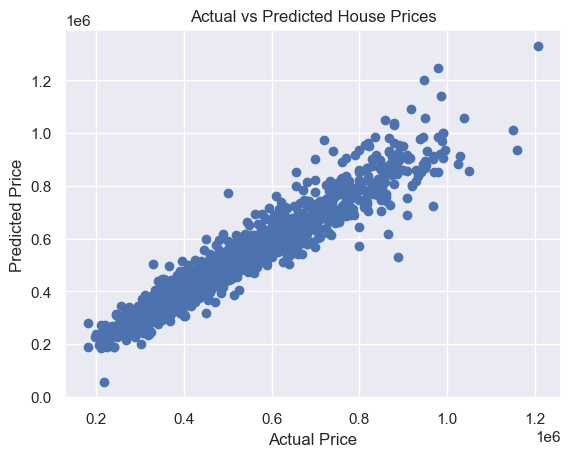

In [13]:
import matplotlib.pyplot as plt

# Plot the actual vs predicted prices
plt.scatter(y_test, y_pred)
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual vs Predicted House Prices")
plt.show()

# Conclusion
The model took too long to run the full dataset, hence I have simply just ran a random 10000 set to gauge the performance of this model. It is clear that using SVR may not be feasible in our model prediction with having so many rows to deal with. The accuracy also did not turn out to be very good, and hence using SVR might not be the best way to predict resale price in our mini project.